# A demo and analysis of Google CANINE-s transformer playing Hangman

In this project, I have trained a character based LLM, Google's Canine-S transformer [1] from random initialisation and fine-tuned it using self-play to achieve optimal game-winning performance.


[1] - Clark, Jonathan H., Garrette, Dan, Turc, Iulia, and Wieting, John. "Canine: Pre-training an Efficient Tokenization-Free Encoder for Language Representation." Transactions of the Association for Computational Linguistics, vol. 10, pp. 73-91, Jan. 2022. DOI: 10.1162/tacl_a_00448. URL: https://doi.org/10.1162/tacl_a_00448.

In [1]:
# Download the best model
!gdown 1FL3Un_8ub82x0xWV8BCn7Bf8UGt4dhBT

Downloading...
From (original): https://drive.google.com/uc?id=1FL3Un_8ub82x0xWV8BCn7Bf8UGt4dhBT
From (redirected): https://drive.google.com/uc?id=1FL3Un_8ub82x0xWV8BCn7Bf8UGt4dhBT&confirm=t&uuid=8ea2b72e-909c-4461-9261-e49f3dae6567
To: /content/canine_best_model.tar.gz
100% 490M/490M [00:09<00:00, 50.9MB/s]


In [2]:
# Extract the model from the tar zipped file
!tar -xvzf canine_best_model.tar.gz

canine_best_model/
canine_best_model/config.json
canine_best_model/model.safetensors


In [3]:
from transformers import CanineTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from tqdm import tqdm
tokenizer = CanineTokenizer.from_pretrained('google/canine-s')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/854 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/657 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

In [4]:
# Tokens used in encoding the hangman states to text for input to the transformer
CANINE_MASK_TOKEN = tokenizer.mask_token
CANINE_SEP_TOKEN = tokenizer.sep_token

In [85]:
def simulate_test_game(word, model, max_wrong_guesses=10, verbose=2):
    '''
    Play a game of hangman with the given word.
    Inputs:
    word: the word to guess
    model: the model to use for the game
    max_guesses: the maximum number of guesses allowed
    Returns:
    True if the word is guessed, False otherwise
    '''
    word_idxs = {}
    all_letters = [chr(i) for i in range(ord('a'), ord('z') + 1)]
    for i, c in enumerate(word):
        if c not in word_idxs:
            word_idxs[c] = []
        word_idxs[c].append(i)
    guesses = {}
    encoded_word = "*" * len(word)
    num_guesses = 0
    while encoded_word != word and num_guesses < max_wrong_guesses:
        state= ''.join(guesses.keys()) + CANINE_SEP_TOKEN + encoded_word.replace('*', CANINE_MASK_TOKEN)
        encoded_state = tokenizer(state, padding="max_length", truncation=True, return_tensors="pt", max_length=64).to(device)
        output = model(**encoded_state)
        output = output.logits.cpu().detach().numpy()
        guess_idx = np.argmax(output)
        guess = all_letters[guess_idx]
        while guess in guesses:
            output[0][guess_idx] = -float('inf')
            guess_idx = np.argmax(output)
            guess = all_letters[guess_idx]
        if guess in word_idxs:
            for i in word_idxs[guess]:
                encoded_word = encoded_word[:i] + guess + encoded_word[i + 1:]
        else:
            num_guesses += 1
        guesses[guess] = True
        if verbose == 2:
            print("Guessing letter:", guess)
            print("Hangman state:", encoded_word)
            print("Number of wrong guesses:", num_guesses)
    if verbose > 0:
        if encoded_word == word:
            print("Correct word:", word)
            print("You win!")
        else:
            print(f"Correct word: {word}, Guessed word: {encoded_word}")
            print("You lose!")
    return encoded_word == word

In [6]:
# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = AutoModelForSequenceClassification.from_pretrained('./canine_best_model')
_ = trained_model.to(device)

Let's now download a text file full of words to evaluate the performance of our model.

In [7]:
!gdown 1JHeYe4hATMLYb-zX7zIT-AlC0FLI5_zi

Downloading...
From: https://drive.google.com/uc?id=1JHeYe4hATMLYb-zX7zIT-AlC0FLI5_zi
To: /content/test_words.txt
100% 52.1k/52.1k [00:00<00:00, 94.6MB/s]


In [8]:
with open('test_words.txt', 'r') as f:
    test_words = f.read().splitlines()

Run the following cell to get the accuracy of model on 1000 test words. This should take about 5 minutes with a T4 GPU. You can skip this step if you only want to play around with the model.

In [ ]:
total_correct = 0
for i in tqdm(range(len(test_words[:1000]))):
    word = test_words[i]
    if simulate_test_game(word, trained_model, max_wrong_guesses=6, verbose=0):
        total_correct += 1
print(f"\nAccuracy: {total_correct / 1000}")

100%|██████████| 1000/1000 [02:48<00:00,  5.92it/s]


Accuracy: 0.63


You can play around with the model in the following cell by giving it random words you can think of and see if it can guess the word or not. Feel free to reduce the number of wrong guesses allowed by changing the max_wrong_guesses parameter below. Can the model still guess your word if it did earlier?

In [ ]:
input_word = input("Enter a word for our model to guess: ")
if input_word.isalpha():
    _ = simulate_test_game(input_word.lower(), trained_model, max_wrong_guesses=10, verbose=2)
else:
    print("Please enter a valid word.")

Enter a word for our model to guess: international
Guessing letter: i
Hangman state: i*******i****
Number of wrong guesses: 0
Guessing letter: n
Hangman state: in***n**i*n**
Number of wrong guesses: 0
Guessing letter: a
Hangman state: in***na*i*na*
Number of wrong guesses: 0
Guessing letter: o
Hangman state: in***na*iona*
Number of wrong guesses: 0
Guessing letter: t
Hangman state: int**nationa*
Number of wrong guesses: 0
Guessing letter: e
Hangman state: inte*nationa*
Number of wrong guesses: 0
Guessing letter: r
Hangman state: internationa*
Number of wrong guesses: 0
Guessing letter: l
Hangman state: international
Number of wrong guesses: 0
Correct word: international
You win!


## Detailed Analysis
###Determining the natural calling order:

Firstly, let us consider how hard our dataset. Remember that shorter words are much harder to guess than longer words. We will have a bit more intuition into this.


In [12]:
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np

In [14]:
!gdown 1957NeZsECBLPywjl_QGKaYq68DarcKVt

Downloading...
From: https://drive.google.com/uc?id=1957NeZsECBLPywjl_QGKaYq68DarcKVt
To: /content/words_alpha.txt
100% 4.23M/4.23M [00:00<00:00, 22.5MB/s]


In [15]:
with open('words_alpha.txt', 'r') as f:
    all_words = f.read().splitlines()

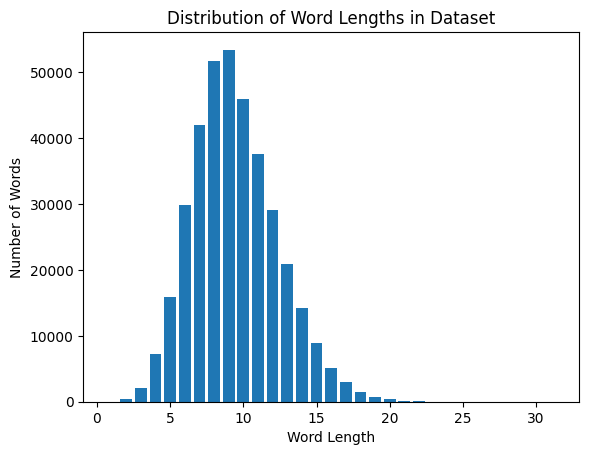

In [20]:
# Get the word lengths and counts from the Counter dictionary
word_lengths = Counter([len(word) for word in all_words])
word_lengths = word_lengths.most_common()
x_vals = [length for length, count in word_lengths]
y_vals = [count for length, count in word_lengths]

# Create the bar plot
plt.bar(x_vals, y_vals)
plt.xlabel("Word Length")
plt.ylabel("Number of Words")
plt.title("Distribution of Word Lengths in Dataset")
plt.show()


In [52]:
word_dict = {}
for length, count in word_lengths:
  if 4 <= length <= 15:
    word_dict[length] = []

for word in all_words:
    length = len(word)
    if 4 <= length <= 15:
        word_dict[length].append(word)

In [61]:
calling_order = {length: [] for length in word_dict}
p_cutoff = 0.999
for length in sorted(word_dict.keys()):
    words = word_dict[length]
    while len(words) / len(word_dict[length]) > 1 - p_cutoff:
        most_frequent = Counter(''.join(words)).most_common(1)[0][0]
        calling_order[length].append(most_frequent)
        words = [word for word in words if most_frequent not in word]
    print(f"Length {length}: {calling_order[length]}")

Length 4: ['a', 'e', 'o', 'i', 'u', 'y', 's', 'r', 'd', 't']
Length 5: ['a', 'e', 'o', 'i', 'u', 'y']
Length 6: ['e', 'a', 'o', 'i', 'u', 'y']
Length 7: ['e', 'a', 'i', 'o', 'u']
Length 8: ['e', 'a', 'i', 'o', 'u']
Length 9: ['e', 'i', 'a', 'o']
Length 10: ['e', 'i', 'o', 'a']
Length 11: ['e', 'i', 'o', 'a']
Length 12: ['e', 'i', 'o', 'a']
Length 13: ['e', 'i', 'o', 'a']
Length 14: ['i', 'e', 'o']
Length 15: ['i', 'e', 'o']


This is the calling order predicted by the entire dataset. This is the order in which one should guess if there are no correct guesses, yet.

Clearly, we see that in our dataset shorter words are harder to guess as they have a longer calling order.

### Analyzing the model's performance on different word lengths

I will now sample 1000 words for each length 4 to 15 and get the accuracy of our model on them. Let us find out how our model fares in each case.

In [87]:
accuracy_lengths = {length: None for length in sorted(word_dict.keys())}
N = 1000
for length in sorted(word_dict.keys()):
    print(f"Length {length}:")
    words = np.random.choice(word_dict[length], N)
    total_correct = 0
    calling_order_counter = set([])
    for i in tqdm(range(len(words))):
        word = words[i]
        if simulate_test_game(word, trained_model, max_wrong_guesses=6, verbose=0):
            total_correct += 1
    accuracy_lengths[length] = total_correct / N
    print(f"\nAccuracy: {accuracy_lengths[length]}")

Length 4:


100%|██████████| 1000/1000 [02:05<00:00,  7.97it/s]



Accuracy: 0.187
Length 5:


100%|██████████| 1000/1000 [02:16<00:00,  7.31it/s]



Accuracy: 0.276
Length 6:


100%|██████████| 1000/1000 [02:25<00:00,  6.87it/s]



Accuracy: 0.33
Length 7:


100%|██████████| 1000/1000 [02:35<00:00,  6.45it/s]



Accuracy: 0.458
Length 8:


100%|██████████| 1000/1000 [02:43<00:00,  6.13it/s]



Accuracy: 0.556
Length 9:


100%|██████████| 1000/1000 [02:49<00:00,  5.90it/s]



Accuracy: 0.68
Length 10:


100%|██████████| 1000/1000 [02:57<00:00,  5.62it/s]



Accuracy: 0.725
Length 11:


100%|██████████| 1000/1000 [02:59<00:00,  5.58it/s]



Accuracy: 0.838
Length 12:


100%|██████████| 1000/1000 [02:59<00:00,  5.56it/s]



Accuracy: 0.875
Length 13:


100%|██████████| 1000/1000 [03:02<00:00,  5.47it/s]



Accuracy: 0.913
Length 14:


100%|██████████| 1000/1000 [03:05<00:00,  5.39it/s]



Accuracy: 0.946
Length 15:


100%|██████████| 1000/1000 [03:07<00:00,  5.32it/s]


Accuracy: 0.959


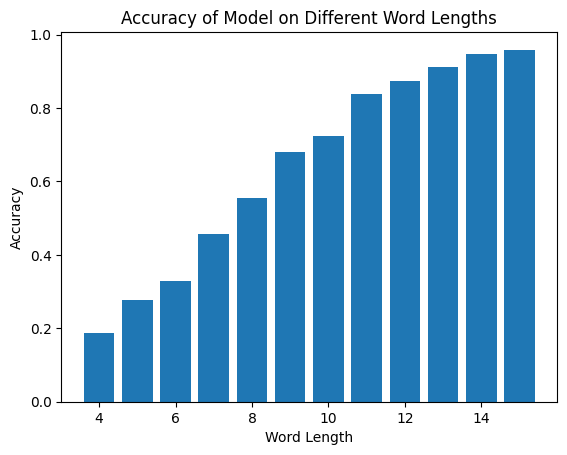

In [88]:
plt.bar(accuracy_lengths.keys(), accuracy_lengths.values())
plt.xlabel("Word Length")
plt.ylabel("Accuracy")
plt.title("Accuracy of Model on Different Word Lengths")
plt.show()